<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/v2.0/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/v2.0/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP and SVElearn from GitHub
Skip this cell if you already have installed HELP and the SVElearn library.

In [ ]:
!pip install -q git+https://github.com/giordamaug/HELP.git
!pip install -q git+https://github.com/giordamaug/SVElearn.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.12620877.svg)](https://doi.org/10.5281/zenodo.12620877)
 the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [23]:
from HELPpy.utility.utils import pdread_csv_fromurl
tissue='Kidney'
X_bio = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_BIO.csv", index_col=0)
X_n2v = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_EmbN2V_128.csv", index_col=0)
X_cccfs = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_CCcfs.csv", index_col=0)
Y = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_HELP.csv", index_col=0)

### 3. Pre-processing and merge input files
We apply pre-processing only to the BIO and CCcfs attributes.
+ constant attributes removal, and
+ data scaling with z-score.  

We also replace `E` label (positive label) and `aE` and `sNE` labels as 0 label (negative label), to address binary `E vs NE` classification.

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df_y = Y.replace({'aE': 0, 'sNE': 0, 'E': 1})              # rename labels to set binary classification E=1, NE=0
print(df_y.value_counts(normalize=False))
def preproc(df):
    consts = df.columns[df.nunique() <= 1].values
    print(f"Removing {len(consts)} constant features ...")
    df = df.drop(consts, axis=1)
    df = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)
    return df
X_bio = preproc(X_bio)
X_cccfs = preproc(X_cccfs)
df_X = pd.merge(X_bio, X_n2v, left_index=True, right_index=True, how='outer')
df_X = pd.merge(df_X, X_cccfs, left_index=True, right_index=True, how='outer')
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X, df_y], axis=1)

label
0        16678
1         1253
Name: count, dtype: int64
Removing 0 constant features ...
Removing 3 constant features ...


### 4. Estimate the performance of EGs prediction 

First we define the metrics we want to measure for perfromance analysis.

In [28]:
from imblearn.metrics import specificity_score
from sklearn.metrics import *
myscorer = { 'ROC-AUC':      (roc_auc_score, {'multi_class':'ovr', 'average':'macro'}),
             'Accuracy'  :   (accuracy_score , {}),
             'BA'  :         (balanced_accuracy_score , {}),
             'Sensitivity' : (recall_score   , {'pos_label': 1}),
             'Specificity' : (specificity_score, {'pos_label': 1}),
            }

The, we instantiate the prediction model developed by ICAR-CNR ([SVElearn](https://github.com/giordamaug/SVElearn)), i.e. the splitting voting ensemble of LightGBM `SplitVotingEnsembleLGBM` with `n_voters=13` classifiers) and estimate its performance via 5-fold cross-validation (`skfold_cv` with `n_splits=5`). Then, print the obtained average performances (`df_scores`)... 

LGBMClassifier(n_estimators=200, random_state=42, verbose=-1)
Classification with sveLGBM...


5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.957±0.005
Accuracy,0.880±0.002
BA,0.891±0.011
Sensitivity,0.903±0.023
Specificity,0.878±0.002
cm,"[[14046, 1948], [120, 1122]]"


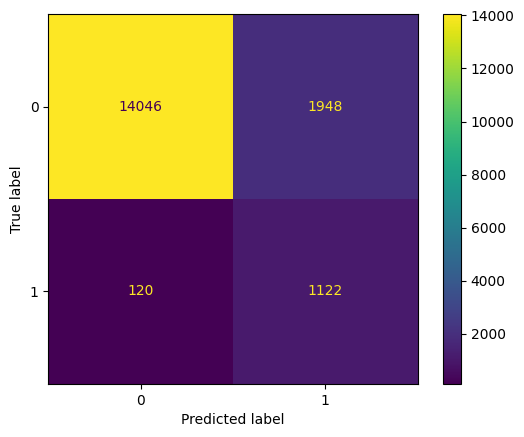

In [29]:
from svelearn.models.splitvotingens import sveLGBM
from svelearn.validation.crossvalidate import skfold_cv
clf = sveLGBM(learning_rate=0.1, n_estimators=200, boosting_type='gbdt', n_jobs=-1, random_state=42)
df_scores, scores, predictions = skfold_cv(df_X, df_y, clf, n_splits=5, seed=0, scorer=myscorer, show_progress=True, verbose=True)
df_scores

### 5. Iterating EG predictions and collecting distributions of metrics
The cross-validation step for EG prediction can be iterated 10 times (`n_repeat=10`). At the end of the iteration loop the performance metrics means and standard deviations are calculated. 

In [30]:
from joblib import Parallel, delayed
from svelearn.validation.crossvalidate import skfold_cv
import os
scores = pd.DataFrame()
preds = pd.DataFrame()
n_folds = 5
n_repeats = 10
n_jobs = -1        # all cpus
verbose = True
clf = sveLGBM(n_voters=13, learning_rate=0.1, n_estimators=200, boosting_type='gbdt', n_jobs=-1, random_state=42)
out = Parallel(n_jobs=n_jobs)(delayed(skfold_cv)(df_X, df_y, clf, n_splits=n_folds, seed=rseed, 
                                               show_progress=True, verbose=verbose, scorer=myscorer) for rseed in range(n_repeats))
for iter,res in enumerate(out):
   scores = pd.concat([scores,res[1]])
   preds = pd.concat([preds,res[2]])
df_scores = pd.DataFrame([f'{val:.4f}±{err:.4f}' for val, err in zip(scores.loc[:, scores.columns != "cm"].mean(axis=0).values,
                          scores.loc[:, scores.columns != "cm"].std(axis=0))] + [(scores[['cm']].sum()/n_repeats).values[0].tolist()],
                          columns=['measure'], index=scores.columns)
display(df_scores)

LGBMClassifier(n_estimators=200, random_state=42, verbose=-1)
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...


5-fold: 100%|██████████| 5/5 [40:40<00:00, 488.14s/it]


Classification with sveLGBM...
Classification with sveLGBM...


5-fold: 100%|██████████| 5/5 [05:23<00:00, 64.63s/it]


,measure
ROC-AUC,0.9579±0.0057
Accuracy,0.8800±0.0048
BA,0.8919±0.0091
Sensitivity,0.9058±0.0183
Specificity,0.8780±0.0052
cm,"[[14042.5, 1951.5], [117.0, 1125.0]]"


#### Display prediction results of last iteration

In [31]:
display(preds)

,label,prediction,probabilities
indices,,,
A1CF,0,0,0.963529
A2M,0,0,0.951503
AAGAB,0,0,0.923012
AARD,0,0,0.999997
AASDH,0,0,0.991770
...,...,...,...
ZRANB2,0,1,0.003258
ZSCAN23,0,0,0.999994
ZSCAN30,0,0,0.999997


### 5. Compute TPR for ucsEGs and csEGs
Read the result files for ucsEGs (`ucsEG_Kidney.txt`) and csEGs (`csEGs_Kidney_EvsNE.csv`) already computed for the tissue, compute the TPRs (tpr) and show their bar plot. 

['ZNG1B'] Not predicted 1 Predicted 59
ucsEG Kidney TPR = 0.797 (47/59) ucsEG Kidney TPR =  0.901 (1119/1242)
[] Not predicted 0 Predicted 28
ucsEG Lung TPR = 0.750 (21/28) ucsEG Lung TPR =  0.913 (1117/1224)
['NOPCHAP1'] Not predicted 1 Predicted 41
ucsEG Brain TPR = 0.659 (27/41) ucsEG Brain TPR =  0.904 (1116/1234)


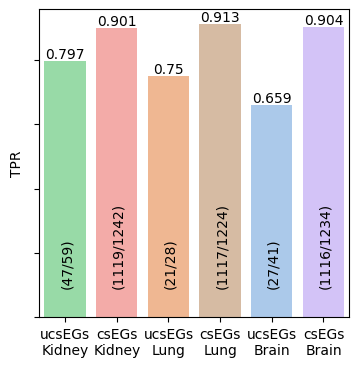

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
tissues = ['Kidney', 'Lung', 'Brain']
path = '../results'
labels = []
data = []
tpr = []
genes = {}
for tissue in tissues:
    #!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/ucsEG_{tissue}.txt
    ucsEGs = pd.read_csv(os.path.join(path,f"ucsEG_{tissue}.txt"), index_col=0, header=None).index.values
    #!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/csEGs_{tissue}_EvsNE.csv
    predictions = pd.read_csv(os.path.join(path,f"pred_{tissue}_EvsNE.csv"), index_col=0)
    indices = np.intersect1d(ucsEGs, predictions.index.values)
    notindices = np.setdiff1d(ucsEGs, predictions.index.values)
    print(notindices, f"Not predicted {len(notindices)}", f"Predicted {len(indices)}")
    preds = predictions.loc[indices]
    num1 = len(preds[preds['label'] == preds['prediction']])
    den1 = len(preds[preds['label'] == 1])
    den2 = len(predictions[predictions['label'] == 1])
    num2 = len(predictions[(predictions['label'] == 1) & (predictions['label'] == predictions['prediction'])])
    labels += [f"ucsEGs\n{tissue}", f"csEGs\n{tissue}"]
    data += [float(f"{num1 /den1:.3f}"), float(f"{num2 /den2:.3f}")]
    tpr += [f"{num1}/{den1}", f"{num2}/{den2}"]
    genes[f'ucsEGs_{tissue}_y'] = preds[preds['label'] == preds['prediction']].index.values
    genes[f'ucsEGs_{tissue}_n'] = preds[preds['label'] != preds['prediction']].index.values
    genes[f'csEGs_{tissue}_y'] = predictions[(predictions['label'] == 1) & (predictions['label'] == predictions['prediction'])].index.values
    genes[f'csEGs_{tissue}_n'] = predictions[(predictions['label'] == 1) & (predictions['label'] != predictions['prediction'])].index.values
    print(f"ucsEG {tissue} TPR = {num1 /den1:.3f} ({num1}/{den1}) ucsEG {tissue} TPR =  {num2/den2:.3f} ({num2}/{den2})")

f, ax = plt.subplots(figsize=(4, 4))
colors = ["#FF0B04", "#FF0B04", "#4374B3", "#4374B3","#ffffff", "#ffffff"]
# Set your custom color palette
customPalette = sns.color_palette("pastel", n_colors=6)
g = sns.barplot(y = data, x = labels, ax=ax, hue= data, palette = customPalette, orient='v', legend=False)
ax.set_ylabel('TPR')
ax.set(yticklabels=[])
for i,l,t in zip(range(len(tissues)*2),labels,tpr):
    ax.text(-0.1 + (i * 1.0), 0.1, f"({t})", rotation='vertical')
for i in ax.containers:
    ax.bar_label(i,)

In [14]:
s = []
for tissue in tissues:
    s += [set(pd.read_csv(os.path.join(path,f"ucsEG_{tissue}.txt"), index_col=0, header=None).index.values)]
f"{tissues[0]}&{tissues[1]} {s[0] & s[1]}" , f"{tissues[0]}&{tissues[2]} {s[0] & s[2]}", f"{tissues[1]}&{tissues[2]} {s[1] & s[2]}", 
f"{tissues[1]}-({tissues[0]}+{tissues[2]}) {s[1] - (s[0] | s[2])}"

"Lung-(Kidney+Brain) {'PI4KA', 'SCD', 'DGCR8', 'CCDC86', 'ZNF407', 'ACO2', 'NUMA1', 'YPEL5', 'TFRC', 'BORA', 'TRPM7', 'ATP5F1D', 'DDX39B', 'NFYB', 'SLC25A3', 'NUP153', 'PPAT', 'PTCD3', 'YTHDC1', 'AP2M1', 'SLBP'}"